Beale synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/beale.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
### Inputs:

obj_func = 'Beale'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'Beale':

    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb = -4.5
    ub = +4.5

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return  operator * (
                (1.500 - x1_training + x1_training * x2_training)**2 +
                (2.250 - x1_training + x1_training * x2_training**2)**2 +
                (2.625 - x1_training + x1_training * x2_training**3)**2
                )


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]

    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = df1 + df2
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t EI exact \t EI approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best)
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2)
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t EI exact \t EI approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best)
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2)
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.74680196  1.98292044]	 6.5970295	 6.5970295	     	     	     	     	    
init	 [-4.49897063 -1.77900685]	 1305.47105896	 6.5970295	     	     	     	     	    
init	 [-3.17919698 -3.66895265]	 28173.77601348	 6.5970295	     	     	     	     	    
init	 [-2.8236581  -1.38995346]	 237.99317641	 6.5970295	     	     	     	     	    
init	 [-0.92909273  0.34935061]	 26.17906318	 6.5970295	     	     	     	     	    
1  	 [-2.52382186 -0.50243815]	 75.02560434	 6.5970295	 23.7 	 120.67945466 	 123.01612377 	 0.981 	 11.363
2  	 [4.23778613 4.5       ]	 155176.68557967	 6.5970295	 23.7 	 6.59728545 	 6.5972854 	 1.0 	 9.9
3  	 [ 4.5 -4.5]	 178131.83203125	 6.5970295	 17.2 	 6.59727403 	 6.59728547 	 1.0 	 11.943
4  	 [-2.50837814 -0.55074818]	 75.86016339	 6.5970295	 19.2 	 6.59691192 	 35.42744954 	 0.186 	 6.058
5  	 [-4.5  4.5]	 169680.83203125	 6.5970295	 19.8 	 6.46839463 	

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.57604588 -4.26666391]	 2377.84417418	 8.81624267	     	     	     	     	    
init	 [ 0.4469623  -0.58209847]	 8.81624267	 8.81624267	     	     	     	     	    
init	 [-0.71668978 -1.52698661]	 47.37426285	 8.81624267	     	     	     	     	    
init	 [-2.65816229  1.0734387 ]	 9.0886159	 8.81624267	     	     	     	     	    
init	 [-1.80310794 -2.09855452]	 510.22209437	 8.81624267	     	     	     	     	    
1  	 [ 0.25377641 -0.62231546]	 10.90772102	 8.81624267	 23.2 	 8.81624482 	 9.24522765 	 0.954 	 12.718
2  	 [4.5 4.5]	 174813.36328125	 8.81624267	 21.8 	 8.81624482 	 8.81624482 	 1.0 	 17.901
3  	 [ 4.5        -2.33754813]	 4204.43670567	 8.81624267	 21.6 	 8.81529854 	 8.81529857 	 1.0 	 14.401
4  	 [-4.5  4.5]	 169680.83203125	 8.81624267	 10.4 	 8.80845 	 8.81411928 	 0.999 	 9.444
5  	 [-2.00866813  0.7528766 ]	 27.98239573	 8.81624267	 9.6 	 11.85785915 	

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.45718112 1.8733304 ]	 41.91271474	 41.91271474	     	     	     	     	    
init	 [-1.88185735  0.09744845]	 47.45118839	 41.91271474	     	     	     	     	    
init	 [3.53652259 3.5666378 ]	 27475.81668992	 41.91271474	     	     	     	     	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973	 41.91271474	     	     	     	     	    
init	 [-4.03679517 -0.53271141]	 138.40865241	 41.91271474	     	     	     	     	    
1	 [-4.5         1.08650849]	 5.13192505	 5.13192505	 23.2 	 41.91232142 	 42.30761565 	 0.991 	 10.305
2  	 [ 2.45032103 -4.5       ]	 52364.08887499	 5.13192505	 24.0 	 5.13499341 	 5.13518553 	 1.0 	 10.425
3  	 [-2.95953733  4.5       ]	 72823.42289439	 5.13192505	 15.9 	 5.13375354 	 5.1340319 	 1.0 	 8.968
4  	 [ 4.5        -0.60867228]	 41.6268128	 5.13192505	 11.6 	 3.65835546 	 4.52284804 	 0.809 	 2.894
5	 [ 1.01667121 -0.38759672]	 4.32894449	 4.32

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [4.20326855 0.42509024]	 3.84098566	 3.84098566	     	     	     	     	    
init	 [4.25415924 1.93334394]	 1070.65181379	 3.84098566	     	     	     	     	    
init	 [ 1.77955942 -2.55519454]	 1001.35293114	 3.84098566	     	     	     	     	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442765	 3.84098566	     	     	     	     	    
init	 [-2.22315874 -0.58687621]	 67.08861689	 3.84098566	     	     	     	     	    
1  	 [-4.5  4.5]	 169680.83203125	 3.84098566	 26.4 	 3.86189148 	 3.86193872 	 1.0 	 11.701
2  	 [-4.5 -4.5]	 181853.61328125	 3.84098566	 19.6 	 3.86078943 	 3.86078943 	 1.0 	 8.229
3  	 [0.88266444 4.5       ]	 7144.04156989	 3.84098566	 6.0 	 3.6377232 	 3.75263077 	 0.969 	 1.169
4  	 [0.3220442  0.44211822]	 11.13956248	 3.84098566	 4.6 	 1.51320213 	 1.6667769 	 0.908 	 0.471
5  	 [0.14122455 0.45965681]	 12.83802482	 3.84098566	 8.6 	 0.02986059 	 0.03

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.50206146  3.33659076]	 8263.90556807	 0.31139702	     	     	     	     	    
init	 [-2.6395276   3.76749817]	 19560.15202528	 0.31139702	     	     	     	     	    
init	 [-0.1042993   1.00569477]	 14.18657899	 0.31139702	     	     	     	     	    
init	 [2.39317071 0.16576189]	 0.31139702	 0.31139702	     	     	     	     	    
init	 [-1.82879549 -2.81050894]	 2208.98230863	 0.31139702	     	     	     	     	    
1  	 [ 3.80474653 -4.48007209]	 123826.98871543	 0.31139702	 15.6 	 0.96323475 	 0.96323475 	 1.0 	 7.94
2  	 [4.5 4.5]	 174813.36328125	 0.31139702	 9.9 	 0.96323473 	 0.96323475 	 1.0 	 8.279
3  	 [-4.5        -0.03093577]	 133.96181403	 0.31139702	 25.5 	 0.94638319 	 0.95803271 	 0.988 	 5.933
4  	 [ 1.44036277 -0.98486004]	 6.75284718	 0.31139702	 12.0 	 0.89386124 	 0.90661463 	 0.986 	 2.523
5  	 [3.98695088 0.03083184]	 10.44705672	 0.31139702	 17.4 	 

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 3.53574136 -1.51218175]	 273.31220308	 10.03800071	     	     	     	     	    
init	 [ 2.89106211 -4.12473037]	 43803.25040669	 10.03800071	     	     	     	     	    
init	 [-3.53108988  0.85546858]	 29.82843375	 10.03800071	     	     	     	     	    
init	 [ 0.26835626 -0.73073314]	 10.6589253	 10.03800071	     	     	     	     	    
init	 [-1.48132936  1.10267489]	 10.03800071	 10.03800071	     	     	     	     	    
1  	 [4.28897718 3.03217734]	 15404.22494396	 10.03800071	 24.2 	 10.0380869 	 10.03800084 	 1.0 	 15.086
2  	 [-4.5        -4.28897303]	 137581.11892584	 10.03800071	 23.6 	 10.03800055 	 10.03799987 	 1.0 	 17.755
3  	 [-4.5  4.5]	 169680.83203125	 10.03800071	 17.4 	 10.03456882 	 10.03529375 	 1.0 	 11.44
4  	 [0.25888316 4.5       ]	 731.87058887	 10.03800071	 12.0 	 9.33494364 	 9.82555113 	 0.95 	 4.553
5  	 [0.69756799 1.00554755]	 14.31115861	 10.

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.8132254   2.51926913]	 3321.1422835	 2.96769239	     	     	     	     	    
init	 [-0.55431692  2.0111866 ]	 2.96769239	 2.96769239	     	     	     	     	    
init	 [4.30190561 0.34646283]	 6.32173172	 2.96769239	     	     	     	     	    
init	 [ 0.01008417 -3.8515398 ]	 11.97189446	 2.96769239	     	     	     	     	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.82031719	 2.96769239	     	     	     	     	    
1  	 [0.32340836 2.08464508]	 41.89604105	 2.96769239	 42.0 	 4.2679345 	 4.2702975 	 0.999 	 12.508
2  	 [-4.5 -4.5]	 181853.61328125	 2.96769239	 25.0 	 3.02828646 	 3.02828646 	 1.0 	 13.491
3  	 [ 4.5 -4.5]	 178131.83203125	 2.96769239	 11.7 	 3.02778188 	 3.02833082 	 1.0 	 7.348
4  	 [4.26128011 4.09845107]	 90157.83576076	 2.96769239	 14.4 	 3.02849842 	 3.02849842 	 1.0 	 5.429
5  	 [ 4.09304963 -0.10138851]	 14.45951416	 2.96769239	 17.2 	 4.47776044

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [3.36086463 4.21686597]	 66731.07602387	 1.86933486	     	     	     	     	    
init	 [3.32275086 0.27770122]	 1.86933486	 1.86933486	     	     	     	     	    
init	 [-2.40544505 -4.39741076]	 45883.36172615	 1.86933486	     	     	     	     	    
init	 [-0.62578064 -0.87883776]	 26.39306085	 1.86933486	     	     	     	     	    
init	 [ 0.20407204 -0.19447384]	 11.649231	 1.86933486	     	     	     	     	    
1  	 [ 3.3388961  -0.41487138]	 11.5661955	 1.86933486	 19.8 	 5.838407 	 5.84396554 	 0.999 	 8.443
2  	 [-3.53253839  4.5       ]	 104136.18514834	 1.86933486	 23.8 	 2.05774054 	 2.05775064 	 1.0 	 10.008
3  	 [-4.5        -0.24288057]	 144.04793458	 1.86933486	 18.3 	 1.10664612 	 1.71990631 	 0.643 	 3.698
4  	 [ 4.5 -4.5]	 178131.83203125	 1.86933486	 14.4 	 2.00120125 	 2.05686854 	 0.973 	 6.107
5	 [ 2.43204405 -0.16656239]	 1.83406758	 1.83406758	 9.3 	 1.

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-4.40663262  0.01687133]	 127.75319006	 22.47920466	     	     	     	     	    
init	 [-0.03804036 -3.29553424]	 22.47920466	 22.47920466	     	     	     	     	    
init	 [-3.22100023 -2.53297192]	 3783.05384026	 22.47920466	     	     	     	     	    
init	 [-0.73342638 -2.26708948]	 157.51337782	 22.47920466	     	     	     	     	    
init	 [-3.74346314 -1.39051224]	 380.77306777	 22.47920466	     	     	     	     	    
1  	 [2.73365793 4.35023323]	 53339.37070055	 22.47920466	 12.6 	 22.47920465 	 22.47920465 	 1.0 	 11.909
2  	 [ 4.5 -4.5]	 178131.83203125	 22.47920466	 24.3 	 22.47920285 	 22.47920465 	 1.0 	 12.267
3  	 [-2.22713742  4.5       ]	 40931.73600273	 22.47920466	 23.7 	 22.47919953 	 22.47920427 	 1.0 	 7.766
4	 [ 2.63820474 -0.1938719 ]	 2.80603743	 2.80603743	 19.5 	 22.47783246 	 22.47915563 	 1.0 	 9.146
5  	 [0.06288071 1.02999938]	 14.2566792	 2.80

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.44188579 -4.31323246]	 40500.70899506	 15.22952398	     	     	     	     	    
init	 [1.20283411 2.23923494]	 281.87686993	 15.22952398	     	     	     	     	    
init	 [-0.01343689 -2.47683019]	 15.22952398	 15.22952398	     	     	     	     	    
init	 [-2.71743422  2.34477641]	 985.56374709	 15.22952398	     	     	     	     	    
init	 [-2.97800247 -3.70494167]	 26177.14611647	 15.22952398	     	     	     	     	    
1  	 [4.5 4.5]	 174813.36328125	 15.22952398	 10.8 	 15.22907914 	 15.22907914 	 1.0 	 9.822
2	 [-0.01745372 -1.49609027]	 14.64317017	 14.64317017	 19.2 	 17.7768663 	 17.81745375 	 0.998 	 7.465
3  	 [ 4.5        -0.27570326]	 25.50165504	 14.64317017	 22.8 	 14.56073903 	 14.63388558 	 0.995 	 8.341
4  	 [-0.5936431   4.43999201]	 2454.53165054	 14.64317017	 33.2 	 14.64314509 	 14.64316919 	 1.0 	 6.21
5	 [ 2.48139531 -0.18352458]	 2.1026749	 2.1026

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.8775728  -4.32472283]	 59421.148191	 2.8907295	     	     	     	     	    
init	 [-0.33103326  2.02440536]	 2.8907295	 2.8907295	     	     	     	     	    
init	 [-0.71816756 -0.13115612]	 25.27144735	 2.8907295	     	     	     	     	    
init	 [-4.38497267 -0.11365553]	 133.25157969	 2.8907295	     	     	     	     	    
init	 [3.97625987 3.1571558 ]	 16859.81677191	 2.8907295	     	     	     	     	    
1  	 [ 4.07281469 -4.5       ]	 145759.65594209	 2.8907295	 23.7 	 2.95697924 	 2.95703954 	 1.0 	 12.43
2  	 [-3.99106031  4.5       ]	 133215.82634685	 2.8907295	 27.6 	 2.93926472 	 2.95703969 	 0.994 	 11.348
3	 [ 1.40155668 -0.4288747 ]	 2.71492229	 2.71492229	 5.6 	 0.19513656 	 1.15322918 	 0.169 	 1.299
4  	 [-0.06577483  1.78284763]	 11.90968852	 2.71492229	 7.8 	 0.54188477 	 1.03834224 	 0.522 	 1.516
5  	 [ 1.41096329 -0.4516701 ]	 2.74555554	 2.71492229	 

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.11253442  2.16044727]	 746.34127209	 48.45196617	     	     	     	     	    
init	 [-2.13016486  0.30365454]	 48.45196617	 48.45196617	     	     	     	     	    
init	 [-4.36882534  3.76872307]	 54651.23560734	 48.45196617	     	     	     	     	    
init	 [ 3.60643369 -4.19920715]	 76007.68460601	 48.45196617	     	     	     	     	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205	 48.45196617	     	     	     	     	    
1	 [-2.48353404  1.41308222]	 3.88229993	 3.88229993	 45.0 	 531.4692994 	 535.07261706 	 0.993 	 13.396
2	 [-2.53343776  1.38512219]	 2.75843705	 2.75843705	 30.4 	 4.9283 	 287.61292016 	 0.017 	 10.496
3  	 [-2.53410635  1.38832747]	 2.90712952	 2.75843705	 30.3 	 2.83519838 	 202.77071213 	 0.014 	 8.542
4  	 [-2.5357251   1.38927937]	 2.96009936	 2.75843705	 32.0 	 143.77722662 	 156.87813498 	 0.916 	 9.296
5  	 [-2.53626742  1.39023789]	 3.00

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.4993217  -2.36212902]	 1312.05970237	 25.91775807	     	     	     	     	    
init	 [2.91850679 4.19174278]	 48757.43948599	 25.91775807	     	     	     	     	    
init	 [ 4.25341003 -0.41895677]	 25.91775807	 25.91775807	     	     	     	     	    
init	 [0.98138216 2.47973863]	 337.87505127	 25.91775807	     	     	     	     	    
init	 [1.2745201  1.99816407]	 177.13741609	 25.91775807	     	     	     	     	    
1	 [0.68948542 0.87887532]	 12.16465006	 12.16465006	 13.8 	 27.71981147 	 27.84717506 	 0.995 	 7.553
2  	 [-3.51625583 -3.70571814]	 36387.21686967	 12.16465006	 13.8 	 12.16465003 	 12.16465003 	 1.0 	 4.708
3  	 [-3.93630846  3.36333617]	 22037.21457254	 12.16465006	 12.2 	 12.16464783 	 12.16464913 	 1.0 	 5.076
4  	 [-1.35877409 -0.02940415]	 37.28812615	 12.16465006	 7.0 	 9.26984341 	 11.64096278 	 0.796 	 2.91
5  	 [ 4.5 -4.5]	 178131.83203125	 12.1

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.12549009 2.45848547]	 30.19066755	 11.36701553	     	     	     	     	    
init	 [ 3.33384917 -4.42757746]	 88548.39506592	 11.36701553	     	     	     	     	    
init	 [-1.71237667  4.11843365]	 13933.41432038	 11.36701553	     	     	     	     	    
init	 [ 0.11805041 -1.63544018]	 11.36701553	 11.36701553	     	     	     	     	    
init	 [ 0.35279944 -2.50870552]	 27.90050047	 11.36701553	     	     	     	     	    
1  	 [0.90889852 1.75180905]	 65.41780665	 11.36701553	 24.9 	 11.40698449 	 11.66275689 	 0.978 	 11.895
2  	 [4.5 4.5]	 174813.36328125	 11.36701553	 29.0 	 11.3670154 	 11.3670154 	 1.0 	 10.161
3  	 [-4.5 -4.5]	 181853.61328125	 11.36701553	 28.2 	 11.36701552 	 11.36701552 	 1.0 	 12.864
4  	 [-4.5         0.43551742]	 96.69787231	 11.36701553	 26.8 	 11.36692591 	 11.36699389 	 1.0 	 14.387
5  	 [ 4.5        -0.08489622]	 19.88170779	 11.36701553	 2

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 3.13935928 -2.88993668]	 6575.87582121	 47.08268654	     	     	     	     	    
init	 [-4.01073107 -1.24615399]	 317.71090829	 47.08268654	     	     	     	     	    
init	 [-2.02139164  0.27000202]	 47.08268654	 47.08268654	     	     	     	     	    
init	 [-1.74672976 -1.75973077]	 234.87929684	 47.08268654	     	     	     	     	    
init	 [-3.49432851 -2.25090888]	 2421.67103335	 47.08268654	     	     	     	     	    
1  	 [-4.5         0.13127822]	 124.4021642	 47.08268654	 21.9 	 49.28380566 	 49.29785274 	 1.0 	 15.477
2  	 [4.5 4.5]	 174813.36328125	 47.08268654	 10.8 	 47.08268653 	 47.08268653 	 1.0 	 15.031
3  	 [-3.10160645  4.48331966]	 78287.83325438	 47.08268654	 21.9 	 47.08268461 	 47.08268534 	 1.0 	 8.98
4	 [1.39449798 1.04201086]	 15.93053412	 15.93053412	 23.2 	 47.08158175 	 47.08188859 	 1.0 	 9.832
5  	 [-0.29639267 -4.5       ]	 917.55412752	 15.

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.49038029  0.20847007]	 59.44289418	 59.44289418	     	     	     	     	    
init	 [ 0.45631311 -4.08958245]	 932.93744896	 59.44289418	     	     	     	     	    
init	 [-1.25344048 -2.49227152]	 594.94949578	 59.44289418	     	     	     	     	    
init	 [ 1.69853546 -3.02641717]	 2418.38944042	 59.44289418	     	     	     	     	    
init	 [-3.8670762   3.96909774]	 58473.38862292	 59.44289418	     	     	     	     	    
1  	 [4.5 4.5]	 174813.36328125	 59.44289418	 20.4 	 59.44289417 	 59.44289417 	 1.0 	 11.173
2	 [ 4.5        -0.44425396]	 31.99700198	 31.99700198	 7.6 	 59.24895973 	 58.19024724 	 1.018 	 11.679
3  	 [-4.5 -4.5]	 181853.61328125	 31.99700198	 17.8 	 31.80306752 	 31.80306752 	 1.0 	 10.813
4	 [0.53239191 1.22742014]	 18.44525073	 18.44525073	 12.2 	 31.53074735 	 31.5313459 	 1.0 	 10.059
5  	 [0.28046865 2.40238232]	 55.31401054	 18.44525073	 8.0 

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.84801498  0.2752808 ]	 43.39160389	 6.89162337	     	     	     	     	    
init	 [-2.77631292 -3.88889678]	 30048.58268622	 6.89162337	     	     	     	     	    
init	 [2.58286914 1.4070017 ]	 81.72560623	 6.89162337	     	     	     	     	    
init	 [1.23768806 0.68042604]	 6.89162337	 6.89162337	     	     	     	     	    
init	 [-4.14843375 -1.27967756]	 359.43439337	 6.89162337	     	     	     	     	    
1  	 [ 4.06562806 -4.5       ]	 145242.79639341	 6.89162337	 18.6 	 6.89176252 	 6.89176713 	 1.0 	 11.345
2  	 [-1.01230281  4.5       ]	 8152.80014985	 6.89162337	 20.2 	 6.8895163 	 6.88951631 	 1.0 	 7.45
3  	 [4.5 4.5]	 174813.36328125	 6.89162337	 12.4 	 6.83571588 	 6.83571588 	 1.0 	 5.066
4	 [2.38979526 0.45297176]	 0.36916453	 0.36916453	 11.8 	 12.14610391 	 12.59322585 	 0.964 	 2.703
5  	 [2.31708739 0.50729762]	 0.7811048	 0.36916453	 15.3 	 2.7449702

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [1.35336818 0.04908036]	 2.47265265	 2.47265265	     	     	     	     	    
init	 [ 3.40741324 -2.86343797]	 7379.01731459	 2.47265265	     	     	     	     	    
init	 [3.17009762 2.25122657]	 1528.31014198	 2.47265265	     	     	     	     	    
init	 [1.49491501 4.39105903]	 17224.91329528	 2.47265265	     	     	     	     	    
init	 [-2.1872842  -4.24524667]	 31030.3482424	 2.47265265	     	     	     	     	    
1  	 [-4.5         2.00329677]	 981.08689208	 2.47265265	 8.0 	 2.57673876 	 2.57673986 	 1.0 	 3.056
2  	 [ 0.37381356 -0.06875589]	 9.8050693	 2.47265265	 8.6 	 3.95920868 	 5.38117553 	 0.736 	 1.878
3  	 [-1.18480482  0.4908165 ]	 27.80923495	 2.47265265	 6.0 	 0.84983452 	 0.87295284 	 0.974 	 0.862
4  	 [-2.63148167  4.5       ]	 57410.32834474	 2.47265265	 4.4 	 0.00079882 	 0.05609996 	 0.014 	 0.332
5  	 [ 0.67343317 -0.10103631]	 6.88855054	 2.47265265

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.62219758  2.35124745]	 1879.40901857	 63.54408607	     	     	     	     	    
init	 [-2.27755824 -3.25681481]	 7496.2434103	 63.54408607	     	     	     	     	    
init	 [-1.51698093 -3.75300391]	 7497.40754262	 63.54408607	     	     	     	     	    
init	 [1.54779373 2.75934418]	 1302.43419574	 63.54408607	     	     	     	     	    
init	 [4.34467723 1.22094661]	 63.54408607	 63.54408607	     	     	     	     	    
1  	 [ 4.5 -4.5]	 178131.83203125	 63.54408607	 11.0 	 63.54311138 	 63.54405432 	 1.0 	 15.994
2  	 [4.5 4.5]	 174813.36328125	 63.54408607	 11.1 	 61.57492828 	 61.57492828 	 1.0 	 4.313
3	 [4.32863431 0.45401562]	 3.83906974	 3.83906974	 13.2 	 60.87916572 	 164.70762008 	 0.37 	 7.132
4  	 [ 1.35122098 -0.73508078]	 3.90975228	 3.83906974	 9.8 	 0.26853851 	 1.74368827 	 0.154 	 1.581
5	 [4.32782814 0.48606641]	 3.09223742	 3.09223742	 6.3 	 0.01060775

In [33]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.79317721 3.57942355]	 1607.3829987	 30.55204393	     	     	     	     	    
init	 [3.52377657 2.8425373 ]	 7209.15006059	 30.55204393	     	     	     	     	    
init	 [-4.17699373  1.72581824]	 253.68900137	 30.55204393	     	     	     	     	    
init	 [-1.09187152  0.16659851]	 30.55204393	 30.55204393	     	     	     	     	    
init	 [ 1.42156319 -2.75534804]	 963.93628383	 30.55204393	     	     	     	     	    
1  	 [-4.5 -4.5]	 181853.61328125	 30.55204393	 7.6 	 30.55204007 	 30.55204007 	 1.0 	 11.339
2  	 [ 4.5 -4.5]	 178131.83203125	 30.55204393	 16.5 	 27.30894051 	 29.63116202 	 0.922 	 3.748
3  	 [-4.5  4.5]	 169680.83203125	 30.55204393	 13.8 	 20.22655046 	 27.98497535 	 0.723 	 11.809
4	 [-4.08149393  0.88697352]	 28.47165083	 28.47165083	 15.4 	 29.02078876 	 59.13087463 	 0.491 	 6.032
5	 [-4.07304487  0.90763983]	 25.6679237	 25.6679237	 17.4 	 26.064

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.74680196  1.98292044]	 6.5970295	 6.5970295	     	     	     	     	    
init	 [-4.49897063 -1.77900685]	 1305.47105896	 6.5970295	     	     	     	     	    
init	 [-3.17919698 -3.66895265]	 28173.77601348	 6.5970295	     	     	     	     	    
init	 [-2.8236581  -1.38995346]	 237.99317641	 6.5970295	     	     	     	     	    
init	 [-0.92909273  0.34935061]	 26.17906318	 6.5970295	     	     	     	     	    
1  	 [-2.36970626 -0.55645492]	 71.2119829	 6.5970295	 16.2 	 120.67945466 	 123.01612377 	 0.981 	 11.95
2  	 [4.5 4.5]	 174813.36328125	 6.5970295	 8.8 	 6.59728545 	 6.59728542 	 1.0 	 15.272
3  	 [ 2.96089888 -3.08880666]	 8543.20937811	 6.5970295	 11.8 	 6.59727409 	 6.59728451 	 1.0 	 3.952
4  	 [-3.30520666 -0.03108115]	 90.08122267	 6.5970295	 8.2 	 15.68961493 	 40.80285284 	 0.385 	 2.704
5  	 [-0.5744994   4.31749386]	 1914.51343894	 6.5970295	 12.0 	 6.

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.57604588 -4.26666391]	 2377.84417418	 8.81624267	     	     	     	     	    
init	 [ 0.4469623  -0.58209847]	 8.81624267	 8.81624267	     	     	     	     	    
init	 [-0.71668978 -1.52698661]	 47.37426285	 8.81624267	     	     	     	     	    
init	 [-2.65816229  1.0734387 ]	 9.0886159	 8.81624267	     	     	     	     	    
init	 [-1.80310794 -2.09855452]	 510.22209437	 8.81624267	     	     	     	     	    
1  	 [4.5 4.5]	 174813.36328125	 8.81624267	 9.1 	 8.81624482 	 9.24522765 	 0.954 	 15.314
2  	 [ 0.27370324 -0.64421743]	 10.65990136	 8.81624267	 19.6 	 9.24234506 	 9.24523368 	 1.0 	 13.105
3  	 [ 4.5        -2.33226482]	 4152.83992213	 8.81624267	 15.4 	 8.81527194 	 8.8152725 	 1.0 	 11.306
4  	 [-1.38505643  4.5       ]	 15540.79407457	 8.81624267	 5.5 	 8.80844797 	 8.8141186 	 0.999 	 9.226
5  	 [-4.5 -4.5]	 181853.61328125	 8.81624267	 2.7 	 7.94086617 

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.45718112 1.8733304 ]	 41.91271474	 41.91271474	     	     	     	     	    
init	 [-1.88185735  0.09744845]	 47.45118839	 41.91271474	     	     	     	     	    
init	 [3.53652259 3.5666378 ]	 27475.81668992	 41.91271474	     	     	     	     	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973	 41.91271474	     	     	     	     	    
init	 [-4.03679517 -0.53271141]	 138.40865241	 41.91271474	     	     	     	     	    
1  	 [ 2.05653972 -2.20902137]	 597.19826137	 41.91271474	 11.3 	 41.91232142 	 42.30761565 	 0.991 	 3.966
2  	 [-2.94491994  4.42400572]	 65033.50571074	 41.91271474	 16.6 	 41.91213688 	 41.91271203 	 1.0 	 3.459
3	 [-0.33703412  0.58613212]	 17.17117685	 17.17117685	 3.4 	 33.45517732 	 39.76218385 	 0.841 	 0.386
4  	 [-0.30200503 -4.44817681]	 892.29667879	 17.17117685	 13.5 	 15.02765424 	 16.74570537 	 0.897 	 6.78
5	 [0.23652124 0.44778653]	 11.92928

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [4.20326855 0.42509024]	 3.84098566	 3.84098566	     	     	     	     	    
init	 [4.25415924 1.93334394]	 1070.65181379	 3.84098566	     	     	     	     	    
init	 [ 1.77955942 -2.55519454]	 1001.35293114	 3.84098566	     	     	     	     	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442765	 3.84098566	     	     	     	     	    
init	 [-2.22315874 -0.58687621]	 67.08861689	 3.84098566	     	     	     	     	    
1  	 [-1.15548213  4.5       ]	 10711.04821623	 3.84098566	 6.9 	 3.86189148 	 3.86193872 	 1.0 	 11.623
2  	 [-4.5 -4.5]	 181853.61328125	 3.84098566	 3.1 	 3.86078929 	 3.86078929 	 1.0 	 5.02
3  	 [-3.67596273  1.01457405]	 12.74169747	 3.84098566	 10.2 	 0.91606809 	 3.38762965 	 0.27 	 0.375
4  	 [0.19349154 0.6524229 ]	 12.80395518	 3.84098566	 1.3 	 1.6216591 	 2.21233657 	 0.733 	 0.348
5  	 [-4.5         0.55717153]	 81.13383476	 3.84098566	 5.6 	 0.49

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.50206146  3.33659076]	 8263.90556807	 0.31139702	     	     	     	     	    
init	 [-2.6395276   3.76749817]	 19560.15202528	 0.31139702	     	     	     	     	    
init	 [-0.1042993   1.00569477]	 14.18657899	 0.31139702	     	     	     	     	    
init	 [2.39317071 0.16576189]	 0.31139702	 0.31139702	     	     	     	     	    
init	 [-1.82879549 -2.81050894]	 2208.98230863	 0.31139702	     	     	     	     	    
1  	 [ 3.80474653 -4.48007209]	 123826.98871543	 0.31139702	 4.8 	 0.96323475 	 0.96323475 	 1.0 	 7.516
2  	 [3.29285857 4.5       ]	 94114.6303521	 0.31139702	 3.3 	 0.96323473 	 0.96323475 	 1.0 	 4.701
3  	 [4.12554738 0.22865825]	 7.69095946	 0.31139702	 14.4 	 0.95102726 	 0.95944936 	 0.991 	 3.967
4  	 [ 1.80691706 -0.85143582]	 6.5667999	 0.31139702	 5.5 	 0.90990403 	 0.92095621 	 0.988 	 1.698
5  	 [ 3.4982641  -0.71382815]	 25.09828511	 0.31139702	

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 3.53574136 -1.51218175]	 273.31220308	 10.03800071	     	     	     	     	    
init	 [ 2.89106211 -4.12473037]	 43803.25040669	 10.03800071	     	     	     	     	    
init	 [-3.53108988  0.85546858]	 29.82843375	 10.03800071	     	     	     	     	    
init	 [ 0.26835626 -0.73073314]	 10.6589253	 10.03800071	     	     	     	     	    
init	 [-1.48132936  1.10267489]	 10.03800071	 10.03800071	     	     	     	     	    
1  	 [4.5        1.29315521]	 97.49404147	 10.03800071	 8.1 	 10.0380869 	 10.03800084 	 1.0 	 16.334
2  	 [-4.5 -4.5]	 181853.61328125	 10.03800071	 12.8 	 10.03800056 	 10.03799989 	 1.0 	 16.446
3  	 [1.34038039 4.48968338]	 15846.11114037	 10.03800071	 10.7 	 10.03772885 	 10.03784561 	 1.0 	 18.241
4  	 [-2.83945502  3.50029479]	 14440.96539433	 10.03800071	 14.6 	 9.72120769 	 10.03527504 	 0.969 	 4.261
5  	 [-1.08929429  0.42426011]	 27.58959024	 1

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.8132254   2.51926913]	 3321.1422835	 2.96769239	     	     	     	     	    
init	 [-0.55431692  2.0111866 ]	 2.96769239	 2.96769239	     	     	     	     	    
init	 [4.30190561 0.34646283]	 6.32173172	 2.96769239	     	     	     	     	    
init	 [ 0.01008417 -3.8515398 ]	 11.97189446	 2.96769239	     	     	     	     	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.82031719	 2.96769239	     	     	     	     	    
1  	 [0.33335076 2.03706478]	 40.4030424	 2.96769239	 7.7 	 4.2679345 	 4.2702975 	 0.999 	 6.282
2  	 [-4.5 -4.5]	 181853.61328125	 2.96769239	 5.2 	 3.02828648 	 3.02828648 	 1.0 	 9.456
3  	 [4.5 4.5]	 174813.36328125	 2.96769239	 2.6 	 3.02780298 	 3.02833082 	 1.0 	 5.065
4  	 [ 2.3497627  -2.80773064]	 3071.44318897	 2.96769239	 5.4 	 3.02849842 	 3.02849842 	 1.0 	 2.367
5  	 [-1.46669149  4.3669769 ]	 14537.03644472	 2.96769239	 4.8 	 3.02849842 	 3.0

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [3.36086463 4.21686597]	 66731.07602387	 1.86933486	     	     	     	     	    
init	 [3.32275086 0.27770122]	 1.86933486	 1.86933486	     	     	     	     	    
init	 [-2.40544505 -4.39741076]	 45883.36172615	 1.86933486	     	     	     	     	    
init	 [-0.62578064 -0.87883776]	 26.39306085	 1.86933486	     	     	     	     	    
init	 [ 0.20407204 -0.19447384]	 11.649231	 1.86933486	     	     	     	     	    
1  	 [ 3.29328857 -0.40328063]	 10.78289563	 1.86933486	 10.8 	 5.838407 	 5.84396554 	 0.999 	 6.057
2  	 [-4.42522463  2.59724938]	 5535.69526567	 1.86933486	 16.2 	 2.05773999 	 2.0577506 	 1.0 	 4.562
3  	 [-0.33624711  1.41514101]	 9.54315584	 1.86933486	 7.2 	 0.75918114 	 0.86129262 	 0.881 	 1.256
4  	 [ 2.74487273 -3.64535999]	 19133.28343791	 1.86933486	 8.0 	 2.0217233 	 2.0572837 	 0.983 	 3.003
5  	 [-0.21134311  1.09596389]	 13.60661602	 1.86933486	 2

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-4.40663262  0.01687133]	 127.75319006	 22.47920466	     	     	     	     	    
init	 [-0.03804036 -3.29553424]	 22.47920466	 22.47920466	     	     	     	     	    
init	 [-3.22100023 -2.53297192]	 3783.05384026	 22.47920466	     	     	     	     	    
init	 [-0.73342638 -2.26708948]	 157.51337782	 22.47920466	     	     	     	     	    
init	 [-3.74346314 -1.39051224]	 380.77306777	 22.47920466	     	     	     	     	    
1  	 [2.73365793 4.35023323]	 53339.37070055	 22.47920466	 4.5 	 22.47920465 	 22.47920465 	 1.0 	 13.487
2  	 [ 3.51004975 -1.83705246]	 696.43607058	 22.47920466	 11.2 	 22.47920285 	 22.47920465 	 1.0 	 15.222
3  	 [-1.95598389  3.25419272]	 4227.87359398	 22.47920466	 10.9 	 22.47919953 	 22.47920456 	 1.0 	 13.233
4	 [0.86980917 0.66073387]	 8.57352732	 8.57352732	 7.4 	 22.47622938 	 22.47625459 	 1.0 	 9.218
5  	 [3.42507379 0.95219299]	 10.163949

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.44188579 -4.31323246]	 40500.70899506	 15.22952398	     	     	     	     	    
init	 [1.20283411 2.23923494]	 281.87686993	 15.22952398	     	     	     	     	    
init	 [-0.01343689 -2.47683019]	 15.22952398	 15.22952398	     	     	     	     	    
init	 [-2.71743422  2.34477641]	 985.56374709	 15.22952398	     	     	     	     	    
init	 [-2.97800247 -3.70494167]	 26177.14611647	 15.22952398	     	     	     	     	    
1  	 [4.5 4.5]	 174813.36328125	 15.22952398	 10.7 	 15.22907914 	 15.22907914 	 1.0 	 8.126
2	 [ 0.01131507 -1.54520536]	 13.91270438	 13.91270438	 16.4 	 17.7768663 	 17.81745375 	 0.998 	 4.653
3	 [ 3.49845019 -0.02375826]	 6.64962063	 6.64962063	 13.8 	 13.82701167 	 13.90323749 	 0.995 	 4.674
4  	 [-0.85490887  4.5       ]	 5742.94673647	 6.64962063	 12.4 	 6.64985011 	 6.64985155 	 1.0 	 4.785
5  	 [-4.5        -0.01811788]	 133.29357958	 6.64962

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.8775728  -4.32472283]	 59421.148191	 2.8907295	     	     	     	     	    
init	 [-0.33103326  2.02440536]	 2.8907295	 2.8907295	     	     	     	     	    
init	 [-0.71816756 -0.13115612]	 25.27144735	 2.8907295	     	     	     	     	    
init	 [-4.38497267 -0.11365553]	 133.25157969	 2.8907295	     	     	     	     	    
init	 [3.97625987 3.1571558 ]	 16859.81677191	 2.8907295	     	     	     	     	    
1  	 [ 3.52189019 -3.07285372]	 11814.47504549	 2.8907295	 14.8 	 2.95697924 	 2.95703954 	 1.0 	 4.628
2  	 [-0.96655529  3.89581054]	 3001.42537175	 2.8907295	 8.2 	 2.83531236 	 2.95587381 	 0.959 	 4.07
3  	 [1.3356093 1.1907064]	 23.524583	 2.8907295	 4.0 	 2.95763386 	 2.9570346 	 1.0 	 5.952
4  	 [-2.96288867 -1.80818793]	 650.26988313	 2.8907295	 1.0 	 2.95704043 	 2.95704043 	 1.0 	 0.0
5  	 [0.02531388 1.26759289]	 14.43132108	 2.8907295	 3.8 	 29.3222644 	 

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.11253442  2.16044727]	 746.34127209	 48.45196617	     	     	     	     	    
init	 [-2.13016486  0.30365454]	 48.45196617	 48.45196617	     	     	     	     	    
init	 [-4.36882534  3.76872307]	 54651.23560734	 48.45196617	     	     	     	     	    
init	 [ 3.60643369 -4.19920715]	 76007.68460601	 48.45196617	     	     	     	     	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205	 48.45196617	     	     	     	     	    
1	 [-2.42439456  1.3891593 ]	 2.41165272	 2.41165272	 5.8 	 531.4692994 	 535.07261706 	 0.993 	 16.387
2  	 [0.50571793 2.79507553]	 211.47950375	 2.41165272	 8.9 	 2.54368507 	 289.2517837 	 0.009 	 8.785
3  	 [-4.5 -4.5]	 181853.61328125	 2.41165272	 5.5 	 2.52251286 	 289.17057973 	 0.009 	 7.974
4  	 [-2.41267629  0.83109538]	 25.95777907	 2.41165272	 7.8 	 135.00324694 	 289.1769506 	 0.467 	 3.268
5  	 [-3.14594382  0.05332993]	 82.37203095	 

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.4993217  -2.36212902]	 1312.05970237	 25.91775807	     	     	     	     	    
init	 [2.91850679 4.19174278]	 48757.43948599	 25.91775807	     	     	     	     	    
init	 [ 4.25341003 -0.41895677]	 25.91775807	 25.91775807	     	     	     	     	    
init	 [0.98138216 2.47973863]	 337.87505127	 25.91775807	     	     	     	     	    
init	 [1.2745201  1.99816407]	 177.13741609	 25.91775807	     	     	     	     	    
1	 [0.8770991  0.76682029]	 9.83935193	 9.83935193	 5.7 	 27.71981147 	 27.84717506 	 0.995 	 13.55
2  	 [-3.51625583 -3.70571814]	 36387.21686967	 9.83935193	 4.1 	 9.83935207 	 9.83935207 	 1.0 	 4.571
3  	 [-3.95052684  2.47322367]	 3170.46964366	 9.83935193	 8.3 	 9.83935041 	 9.83935107 	 1.0 	 1.978
4  	 [-0.32447944 -1.3526273 ]	 23.12768659	 9.83935193	 2.5 	 6.95807517 	 9.33951266 	 0.745 	 1.015
5	 [3.47375088 0.46543694]	 0.59796076	 0.59796076	 

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.12549009 2.45848547]	 30.19066755	 11.36701553	     	     	     	     	    
init	 [ 3.33384917 -4.42757746]	 88548.39506592	 11.36701553	     	     	     	     	    
init	 [-1.71237667  4.11843365]	 13933.41432038	 11.36701553	     	     	     	     	    
init	 [ 0.11805041 -1.63544018]	 11.36701553	 11.36701553	     	     	     	     	    
init	 [ 0.35279944 -2.50870552]	 27.90050047	 11.36701553	     	     	     	     	    
1  	 [1.53232195 1.11653614]	 20.12801748	 11.36701553	 5.0 	 11.40698449 	 11.66275689 	 0.978 	 11.979
2  	 [-4.5        -0.35286124]	 149.51029819	 11.36701553	 7.7 	 11.36701535 	 11.36701532 	 1.0 	 10.352
3  	 [4.5 4.5]	 174813.36328125	 11.36701553	 12.8 	 11.36701535 	 11.36701428 	 1.0 	 14.356
4  	 [-3.44638717 -4.5       ]	 107005.3218652	 11.36701553	 12.2 	 11.36700654 	 11.36700674 	 1.0 	 10.297
5  	 [ 4.19389567 -0.6362805 ]	 35.83422152	 

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 3.13935928 -2.88993668]	 6575.87582121	 47.08268654	     	     	     	     	    
init	 [-4.01073107 -1.24615399]	 317.71090829	 47.08268654	     	     	     	     	    
init	 [-2.02139164  0.27000202]	 47.08268654	 47.08268654	     	     	     	     	    
init	 [-1.74672976 -1.75973077]	 234.87929684	 47.08268654	     	     	     	     	    
init	 [-3.49432851 -2.25090888]	 2421.67103335	 47.08268654	     	     	     	     	    
1  	 [-4.5         0.10054922]	 126.4259099	 47.08268654	 11.6 	 49.28380566 	 49.29785274 	 1.0 	 18.03
2  	 [4.5 4.5]	 174813.36328125	 47.08268654	 3.6 	 47.08268653 	 47.08268653 	 1.0 	 15.372
3  	 [-0.84090611  4.43221619]	 5047.41799682	 47.08268654	 7.3 	 47.08268507 	 47.08268561 	 1.0 	 7.533
4	 [1.08910464 1.14711382]	 19.59668492	 19.59668492	 14.6 	 47.07598188 	 47.08147437 	 1.0 	 11.565
5  	 [-4.49028497  3.28499764]	 24939.53941196	 19.

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.49038029  0.20847007]	 59.44289418	 59.44289418	     	     	     	     	    
init	 [ 0.45631311 -4.08958245]	 932.93744896	 59.44289418	     	     	     	     	    
init	 [-1.25344048 -2.49227152]	 594.94949578	 59.44289418	     	     	     	     	    
init	 [ 1.69853546 -3.02641717]	 2418.38944042	 59.44289418	     	     	     	     	    
init	 [-3.8670762   3.96909774]	 58473.38862292	 59.44289418	     	     	     	     	    
1  	 [4.5 4.5]	 174813.36328125	 59.44289418	 2.8 	 59.44289417 	 59.44289417 	 1.0 	 15.552
2  	 [-4.5 -4.5]	 181853.61328125	 59.44289418	 9.9 	 59.24895973 	 58.19024724 	 1.018 	 6.696
3	 [0.30512323 1.6014472 ]	 23.03969577	 23.03969577	 20.8 	 58.74656255 	 58.97869679 	 0.996 	 4.09
4	 [ 3.85542302 -0.12260549]	 11.92439135	 11.92439135	 8.3 	 19.72508833 	 21.7867934 	 0.905 	 2.778
5  	 [-0.00709002  0.55924446]	 14.26520643	 11.92439135	 2.0 

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.84801498  0.2752808 ]	 43.39160389	 6.89162337	     	     	     	     	    
init	 [-2.77631292 -3.88889678]	 30048.58268622	 6.89162337	     	     	     	     	    
init	 [2.58286914 1.4070017 ]	 81.72560623	 6.89162337	     	     	     	     	    
init	 [1.23768806 0.68042604]	 6.89162337	 6.89162337	     	     	     	     	    
init	 [-4.14843375 -1.27967756]	 359.43439337	 6.89162337	     	     	     	     	    
1  	 [ 4.35943059 -3.9087003 ]	 73234.01298704	 6.89162337	 16.4 	 6.89176252 	 6.89176713 	 1.0 	 8.325
2  	 [-1.00950125  4.5       ]	 8106.22195621	 6.89162337	 10.0 	 6.88951645 	 6.88951646 	 1.0 	 11.656
3  	 [4.5 4.5]	 174813.36328125	 6.89162337	 2.4 	 6.83570875 	 6.83570875 	 1.0 	 4.214
4	 [2.66614346 0.31249071]	 0.13677664	 0.13677664	 8.8 	 11.19524054 	 12.34611267 	 0.907 	 0.602
5  	 [2.95002527 0.22333079]	 1.01703306	 0.13677664	 5.4 	 0.6669717 

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [1.35336818 0.04908036]	 2.47265265	 2.47265265	     	     	     	     	    
init	 [ 3.40741324 -2.86343797]	 7379.01731459	 2.47265265	     	     	     	     	    
init	 [3.17009762 2.25122657]	 1528.31014198	 2.47265265	     	     	     	     	    
init	 [1.49491501 4.39105903]	 17224.91329528	 2.47265265	     	     	     	     	    
init	 [-2.1872842  -4.24524667]	 31030.3482424	 2.47265265	     	     	     	     	    
1  	 [-4.5         1.90816143]	 682.25927677	 2.47265265	 5.0 	 2.57673876 	 2.57673986 	 1.0 	 1.221
2  	 [-0.21418539  0.24550652]	 16.81265861	 2.47265265	 3.4 	 3.96111549 	 5.38123775 	 0.736 	 1.058
3  	 [ 0.56201494 -0.03993594]	 7.9462944	 2.47265265	 6.7 	 0.45720046 	 0.5852935 	 0.781 	 1.327
4  	 [-1.68876831  0.36036805]	 38.42471801	 2.47265265	 3.2 	 0.06921188 	 0.35455947 	 0.195 	 0.358
5  	 [-0.05787514  0.37788318]	 14.82859343	 2.47265265	 1

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.62219758  2.35124745]	 1879.40901857	 63.54408607	     	     	     	     	    
init	 [-2.27755824 -3.25681481]	 7496.2434103	 63.54408607	     	     	     	     	    
init	 [-1.51698093 -3.75300391]	 7497.40754262	 63.54408607	     	     	     	     	    
init	 [1.54779373 2.75934418]	 1302.43419574	 63.54408607	     	     	     	     	    
init	 [4.34467723 1.22094661]	 63.54408607	 63.54408607	     	     	     	     	    
1  	 [ 4.07377978 -3.44761015]	 30801.17166457	 63.54408607	 5.4 	 63.54311138 	 63.54405432 	 1.0 	 17.936
2  	 [4.5 4.5]	 174813.36328125	 63.54408607	 3.6 	 61.57553905 	 61.57553905 	 1.0 	 8.978
3	 [ 1.04923617 -0.60142941]	 4.3455891	 4.3455891	 4.5 	 58.21405998 	 59.20951271 	 0.983 	 1.194
4  	 [-0.01122721 -0.06586462]	 14.34868228	 4.3455891	 2.4 	 0.46186595 	 0.96713883 	 0.478 	 0.113
5	 [2.89370911 0.76065801]	 2.72378623	 2.72378623	 3.8 	 

In [53]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.79317721 3.57942355]	 1607.3829987	 30.55204393	     	     	     	     	    
init	 [3.52377657 2.8425373 ]	 7209.15006059	 30.55204393	     	     	     	     	    
init	 [-4.17699373  1.72581824]	 253.68900137	 30.55204393	     	     	     	     	    
init	 [-1.09187152  0.16659851]	 30.55204393	 30.55204393	     	     	     	     	    
init	 [ 1.42156319 -2.75534804]	 963.93628383	 30.55204393	     	     	     	     	    
1  	 [-4.5 -4.5]	 181853.61328125	 30.55204393	 3.7 	 30.55204007 	 30.55204007 	 1.0 	 12.014
2  	 [ 4.27466108 -1.09266217]	 117.13091933	 30.55204393	 11.8 	 27.30894051 	 29.63116202 	 0.922 	 2.7
3  	 [-1.70805604 -0.80051458]	 56.27018225	 30.55204393	 7.2 	 20.14571445 	 29.46414979 	 0.684 	 1.98
4  	 [-2.55732664  3.6797256 ]	 15859.5605746	 30.55204393	 11.2 	 22.68201436 	 29.46417204 	 0.77 	 2.292
5	 [0.41602025 0.21721859]	 9.71340553	 9.713405

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.04703681559288557, -1.321396349484615)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(1.2298244149325677, 0.8040099598567838)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(0.12289565381490877, 0.060447131196057984)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-2.1266463442484316, -2.1266463442484316)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-1.1666865916873388, -1.5022078093359148)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(0.05684211797121335, -0.9943494563209562)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(0.14657079029250603, 1.087784678899565)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(0.44405107016636686, -0.7540537081068912)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-3.0759462632596346, -1.045861676639085)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(-1.3643573037905479, -0.35141435680937805)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-0.43317310474328835, 0.12914577414874612)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(1.0146642345944255, -0.847148345323759)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(0.29262608495910813, -4.478356331341319)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(0.43594180066530913, -1.591948223550342)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(1.1533856759067456, 1.4858412266854037)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(-1.7231402936209812, -1.9848830960069965)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-0.9965128466531128, -2.9523904525907474)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(0.38120661329448713, 0.5694998544240025)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(0.943715724660027, -2.4429258622164745)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(1.541586629729168, 1.375558906521904)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[-6.597029498756062,
 120.67945466375741,
 123.01612377247451,
 16.2,
 11.949728591452702,
 -6.597029498756062,
 6.597285451772171,
 6.597285420779917,
 8.8,
 15.272053978275508,
 -6.597029498756062,
 6.5972740873662,
 6.5972845066011,
 11.8,
 3.9521222046371918,
 -6.597029498756062,
 15.689614931064883,
 40.80285283599606,
 8.2,
 2.704417369507654,
 -6.597029498756062,
 6.441736217801322,
 22.992312174839007,
 12.0,
 4.74605567134692,
 -6.597029498756062,
 9.325631789522602,
 22.69161899524731,
 6.8,
 1.5697133418925426,
 -6.597029498756062,
 14.787057912337357,
 22.807878832548486,
 5.4,
 1.6820224911665511,
 -6.597029498756062,
 5.538009745737084,
 6.4277213063791745,
 5.8,
 2.025515331749224,
 -6.597029498756062,
 0.5150296913583781,
 5.334393752649173,
 3.2,
 0.33859968167950194,
 -0.2667625480325752,
 0.278518568596479,
 0.7804950377456277,
 3.4,
 0.43655647741161696,
 -0.2667625480325752,
 0.0018093276576821079,
 0.6410570779691582,
 1.4,
 0.40962980511363023,
 -0.26676254803257

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([6.5970295 , 6.5970295 , 6.5970295 , 6.5970295 , 6.5970295 ,
       6.5970295 , 6.5970295 , 6.5970295 , 0.26676255, 0.26676255,
       0.26676255, 0.26676255, 0.26676255, 0.26676255, 0.26676255,
       0.26676255, 0.26676255, 0.26676255, 0.26676255, 0.26676255])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(0.17891624954759489, 0.9320575533481914, 2.23448317531831, 3.4206288722062075)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(2.9202972976428027e-08,
 2.9202972976428027e-08,
 1.062311432950786,
 1.1307664236287764)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(1.454549640451438e-13,
 1.454549640451438e-13,
 0.11923650225605985,
 0.11923650225605985)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(3.869971467809698e-12,
 3.869971467809698e-12,
 0.22263807471302513,
 0.311397019260738)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(0.449303949585308,
 0.4537848846429688,
 0.36996404404565864,
 1.0584886808620901)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(4.267934495145905, 4.270297504409457, 2.9676923934097053, 1.1578568929454924)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(0.7142930040426225,
 5.180645126314358,
 0.47045559247114155,
 1.5590101024941765)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(16.0294750947696,
 16.31827162299437,
 0.35138890527889544,
 0.046145941506268745)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(1.1928218814598106,
 1.2042113892311677,
 0.7036921138192095,
 0.2555448609353727)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(0.08718231403268849,
 0.27638653153959075,
 1.137855982063722,
 0.6484482326241139)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(0.49945932212249183,
 0.5015736109391744,
 0.42863551124630517,
 2.7584370541317442)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(0.0030071670090560726,
 0.09372426846472429,
 0.011352056848495828,
 1.3399416724045063)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(0.6042481763028499,
 15.385020923332887,
 0.20352870581118873,
 1.546418791585517)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(0.6509839874109873, 0.6653537145694697, 4.418680962089445, 3.1689036486471203)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(14.227189435687507,
 40.426610648104024,
 0.13739667539810144,
 0.1785047096313805)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(2.897461233677553,
 3.8388323720372166,
 0.05221473978510092,
 0.3691645325490724)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(4.376612898224361e-25,
 4.376612898224361e-25,
 1.7673828816160209,
 1.4640500663699316)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(61.50676720753971, 86.85785986995582, 0.08690620353397152, 2.569511298655627)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(6.239364296917338, 13.92478829471279, 3.9572878589472626, 4.671997122998433)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(20.2, 3.2)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(17.6, 4.6)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(5.4, 1.0)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(3.0, 1.0)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(15.6, 1.0)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(7.8, 8.3)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(16.8, 7.7)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(7.6, 3.4)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(17.8, 3.4)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(7.2, 2.9)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(3.0, 2.4)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(30.4, 2.5)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(10.6, 3.6)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(4.5, 2.5)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(11.6, 7.4)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(8.0, 3.1)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(11.8, 3.8)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(3.0, 1.0)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(9.8, 2.6)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(12.3, 7.5)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(5.157411319065135, 2.4161700209790102)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(5.201314836548894, 3.2191748815913757)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(2.450928519936194, 1.0161462500211875)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(1.6643643581912198, 1.0016033936827509)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(3.0518530033798514, 1.601174406651479)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(4.5163280463271, 3.595210811388236)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(3.568249152189252, 1.7041468032974159)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(2.7896571811095114, 0.8914796311000938)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(3.953958294663844, 4.807575818265424)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(2.144774524179465, 1.306957123181964)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(1.9447470790794863, 1.172267722291339)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(9.464947861458409, 3.275242309737597)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(2.1871418056320238, 1.4436501278919458)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(4.408813751000183, 3.8643559447353724)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(4.263767767204185, 3.8755742156895785)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(3.0326320071559136, 1.549763724587104)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(2.6532660480976773, 1.6717944423827773)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(0.5292600215511335, 0.46963420725191013)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(2.130116730436316, 1.5879700234772096)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(2.9629707301403787, 1.8258133914258896)

In [157]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP EI maximum (when compared to GP dEI, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dEI maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP EI, resultant tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dEI, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP EI, average nfev at tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(11.200000000000001, 3.6449999999999996)

In [162]:
### Summarise arrays: 'GP EI, average Euclid at tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(3.4038251518673093, 2.114785262481483)

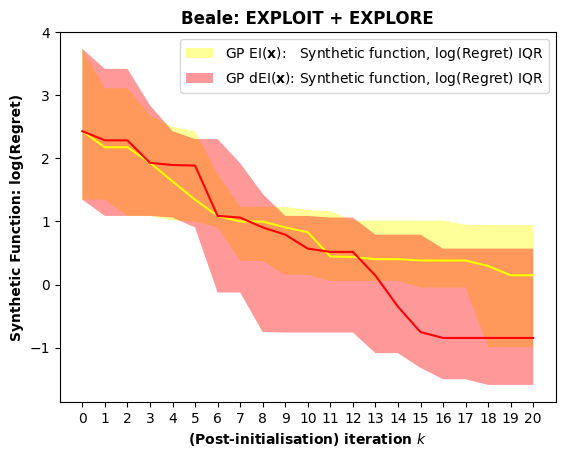

In [163]:
### Visualise!

ei_both = ': EXPLOIT + EXPLORE'
title = obj_func + ei_both

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


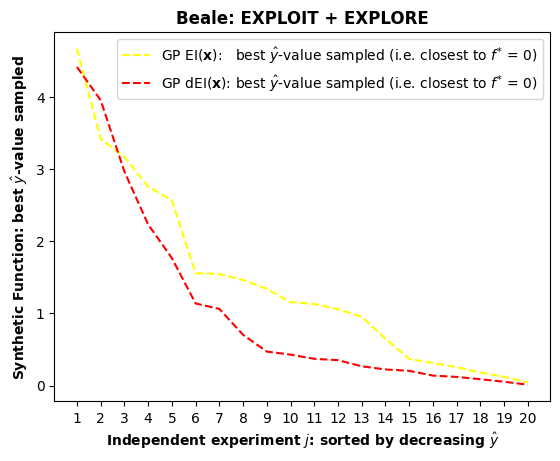

In [164]:
### Visualise!

ei_both = ': EXPLOIT + EXPLORE'
title = obj_func + ei_both

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Yellow', ls='--', label='GP EI($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Red', ls='--', label='GP dEI($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


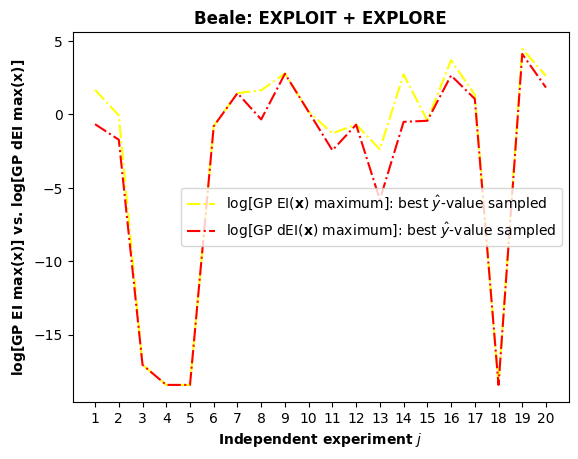

In [165]:
### Visualise!

ei_both = ': EXPLOIT + EXPLORE'
title = obj_func + ei_both

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Yellow', ls='-.', label='log[GP EI($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Red', ls='-.', label='log[GP dEI($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP EI max($\mathbf{x}$)] vs. log[GP dEI max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


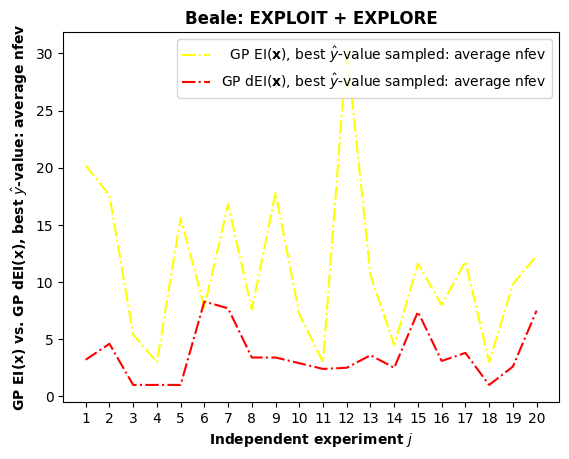

In [166]:
### Visualise!

ei_both = ': EXPLOIT + EXPLORE'
title = obj_func + ei_both

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Yellow', ls='-.', label='  GP EI($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$) vs. GP dEI($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


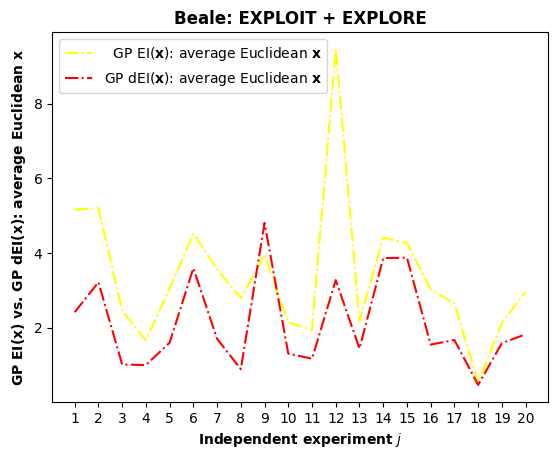

In [167]:
### Visualise!

ei_both = ': EXPLOIT + EXPLORE'
title = obj_func + ei_both

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Yellow', ls='-.', label='  GP EI($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$) vs. GP dEI($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 0.0,
 array([-1.21095663, -0.25525958]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 0.0,
 array([-1.21095663, -0.25525958]))

In [170]:
np.round(approx_4.x_best, 4)


array([[-1.211 , -0.2553],
       [-4.3683, -2.832 ],
       [ 0.5022,  1.5938],
       [ 1.3008,  4.028 ],
       [-1.2393,  3.2584],
       [ 2.2579,  1.7829],
       [ 3.094 ,  3.5193],
       [ 1.7737, -3.9383],
       [-2.7917,  0.5702],
       [ 0.4952,  4.2244],
       [ 0.5914,  2.7947],
       [ 1.1803, -3.6823],
       [-1.2694, -0.2297],
       [-3.1738, -0.3069],
       [ 0.7888,  2.6758],
       [ 1.4255,  3.1558],
       [ 3.2391, -3.9201],
       [ 3.8448, -0.6481],
       [ 1.1442, -1.9423],
       [-1.8664, -0.0634]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[-1.211 , -0.2553],
       [-4.3683, -2.832 ],
       [ 0.5022,  1.5938],
       [ 1.3008,  4.028 ],
       [-1.2393,  3.2584],
       [ 2.2579,  1.7829],
       [ 3.094 ,  3.5193],
       [ 1.7737, -3.9383],
       [-2.7917,  0.5702],
       [ 0.4952,  4.2244],
       [ 0.5914,  2.7947],
       [ 1.1803, -3.6823],
       [-1.2694, -0.2297],
       [-3.1738, -0.3069],
       [ 0.7888,  2.6758],
       [ 1.4255,  3.1558],
       [ 3.2391, -3.9201],
       [ 3.8448, -0.6481],
       [ 1.1442, -1.9423],
       [-1.8664, -0.0634]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


0.0

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

0.0